In [1]:
# testing objects for n-dim tead

In [2]:
import torch
from botorch.models.gp_regression import ExactGP
from scipy.stats.qmc import LatinHypercube
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [84]:
# test using true function rather than model
dtype = torch.double
def f_test(x):
    return torch.sin(x).sum(dim=1, keepdim=True)
h = 1e-4
x = torch.rand(20, 2, dtype=dtype)
num_data = x.shape[0]
num_dim = x.shape[1]
delta_s = torch.zeros(num_data, num_dim)
for i in range(0, num_data):
    for j in range(0, num_dim):
        dx = torch.zeros(1, num_dim)
        dx[:,j] = h  # set the dimension for the gradient to have a step
        x_lo = x[i] - dx  # element-wise subtract
        x_hi = x[i] + dx  # element-wise addition
        y_lo = f_test(x_lo)  # unsqueeze to match model syntax
        y_hi = f_test(x_hi)  # unsqueeze to match model syntax
        delta_s[i, j] = (y_hi - y_lo)/(2*h)

In [85]:
delta_s

tensor([[0.9844, 0.6934],
        [0.9841, 0.8323],
        [0.6485, 0.7158],
        [0.9577, 0.9746],
        [0.9907, 0.7200],
        [0.9451, 0.9059],
        [0.9012, 0.6410],
        [0.9759, 0.9635],
        [0.9896, 0.9750],
        [0.9964, 0.9930],
        [0.8037, 0.9663],
        [0.9608, 0.7145],
        [0.7672, 0.9873],
        [0.8886, 0.8604],
        [0.9977, 0.7208],
        [0.9830, 0.7669],
        [0.9907, 0.7383],
        [0.9976, 0.9974],
        [0.8876, 0.9699],
        [0.9748, 0.9314]])

In [86]:
torch.cos(x[0])

tensor([0.9844, 0.6934], dtype=torch.float64)

In [139]:
dtype = torch.double
def nfinite_diff(model):
    """get approx gradient at model training points"""
    # assumes 1d input... see implementation in [3] for update to n-D
    h = 1e-4
    x = model.train_inputs[0]
    num_data = x.shape[0]
    num_dim = x.shape[1]
    delta_s = torch.zeros(num_data, num_dim, dtype=dtype)
    for i in range(0, num_data):
        for j in range(0, num_dim):
            dx = torch.zeros(1, num_dim)
            dx[:,j] = h  # set the dimension for the gradient to have a step
            x_lo = x[i] - dx  # element-wise subtract
            x_hi = x[i] + dx  # element-wise addition
            y_lo = model(x_lo.unsqueeze(0)).mean  # unsqueeze to match model syntax
            y_hi = model(x_hi.unsqueeze(0)).mean  # unsqueeze to match model syntax
            delta_s[i, j] = (y_hi - y_lo)/(2*h)
    return delta_s

In [140]:
dtype = torch.double
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll

train_X = torch.rand(20, 2, dtype=dtype)
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
model_example = SingleTaskGP(train_X, train_Y)
mll_example = ExactMarginalLogLikelihood(model_example.likelihood, model_example)
fitting = fit_gpytorch_mll(mll_example)
delta_s = nfinite_diff(model_example)

In [77]:
temp = nfinite_diff(model_example)

In [88]:
def nknn(ref, query, k=1):
    """Function to wrap KNN from sklearn for TEAD setup
    assumes 1d input dimension, torch Tensors, ref is training inputs
    query is candidate points, k is number of neighbors
    """
    knn_ex = NearestNeighbors(n_neighbors=k).fit(ref.squeeze().numpy().reshape(-1, 1))
    dists, indices = knn_ex.kneighbors(query.squeeze().numpy().reshape(-1, 1))
    return dists, indices

In [141]:
x_train = train_X

lhs_sampler = LatinHypercube(d=x_train.shape[1])
num_cands = 2000
cands = torch.tensor(lhs_sampler.random(n=num_cands), dtype=dtype)
# calculate nearest neighbors pairings for the candidates
# dists, inds = nknn(x_train, cands)
nn = NearestNeighbors(n_neighbors=1).fit(x_train)
dists, inds = nn.kneighbors(cands)
dists = torch.tensor(dists, dtype=dtype)
inds = torch.tensor(inds)
# calculate the weighting
sample_dists = []
vals = x_train
for i in range(len(vals)):
    for j in range(len(vals)):
        sample_dists.append(torch.linalg.norm(vals[i]-vals[j]))
lmax = max(sample_dists)

In [143]:
# test taylor expansion part
w = torch.ones(num_cands, 1, dtype=dtype) - dists/lmax
# do taylor series expansions
t = torch.zeros(num_cands, 1, dtype=dtype)
s = torch.zeros(num_cands, 1, dtype=dtype)
res = torch.zeros(num_cands, 1, dtype=dtype)
for i in range(num_cands):
    g = x_train[inds[i]].squeeze() - cands[i]
    t[i] = train_Y[inds[i]].squeeze() + torch.dot(delta_s[inds[i]].squeeze(), g)
    s[i] = model_example(cands[i].unsqueeze(0)).mean
    res[i] = torch.norm(s[i, 0] - t[i, 0])

# compute score
j = (dists/max(dists)) + w * (res / max(res))

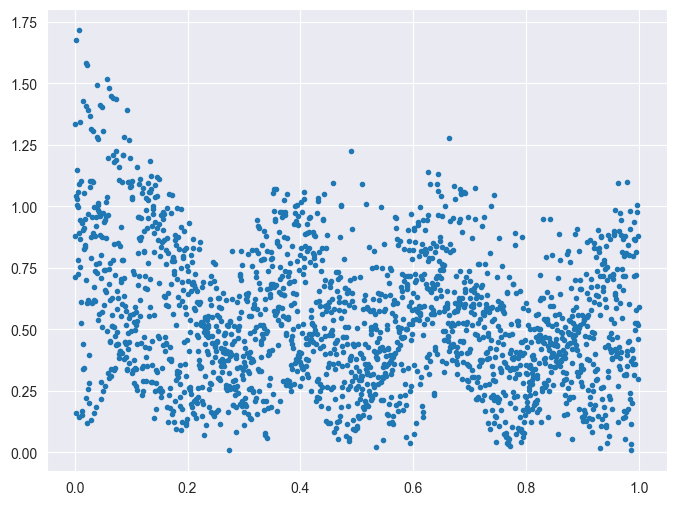

In [145]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(cands.numpy()[:,0], j.detach().numpy(), '.')

In [125]:
g = x_train[inds[0]].squeeze() - cands[0]

In [129]:
train_Y[inds[i]].squeeze() + delta_s[inds[i]].squeeze()*g

tensor([0.5116, 0.6251], dtype=torch.float64)

In [130]:
train_Y[inds[i]]

tensor([[0.6518]], dtype=torch.float64)

In [101]:
# torch?
t_dists = torch.tensor(dists)
t_inds = torch.tensor(inds)
x_train[t_inds[0]]

tensor([[0.9260, 0.4882]], dtype=torch.float64)

In [99]:
# knn test
test_nn = NearestNeighbors(n_neighbors=1).fit(x_train)
test_dists, test_indices = test_nn.kneighbors(cands)

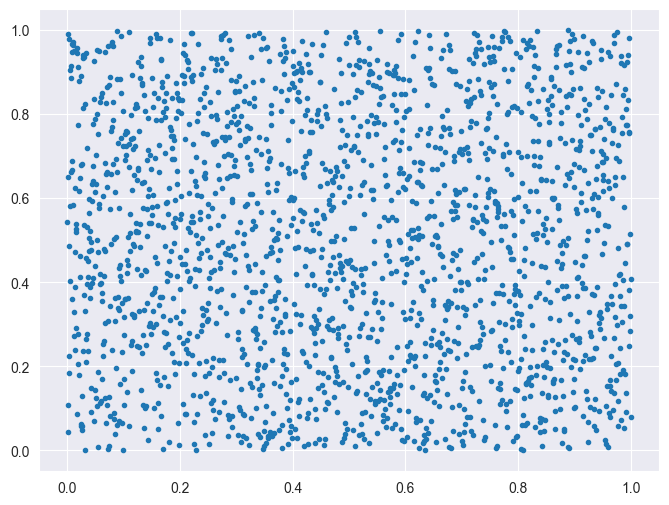

In [96]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(cands.numpy()[:,0], cands.numpy()[:,1], '.')

In [148]:
# final test
import torch
from botorch.models import SingleTaskGP
from scipy.stats.qmc import LatinHypercube
from sklearn.neighbors import NearestNeighbors
import numpy as np

dtype = torch.double

In [149]:
def nfinite_diff(model):
    """get approx gradient at model training points"""
    # assumes 1d input... see implementation in [3] for update to n-D
    h = 1e-4
    x = model.train_inputs[0]
    num_data = x.shape[0]
    num_dim = x.shape[1]
    delta_s = torch.zeros(num_data, num_dim, dtype=dtype)
    for i in range(0, num_data):
        for j in range(0, num_dim):
            dx = torch.zeros(1, num_dim)
            dx[:,j] = h  # set the dimension for the gradient to have a step
            x_lo = x[i] - dx  # element-wise subtract
            x_hi = x[i] + dx  # element-wise addition
            y_lo = model(x_lo.unsqueeze(0)).mean  # unsqueeze to match model syntax
            y_hi = model(x_hi.unsqueeze(0)).mean  # unsqueeze to match model syntax
            delta_s[i, j] = (y_hi - y_lo)/(2*h)
    return delta_s

def nglobal_tead(model: SingleTaskGP, get_all_candidates: bool = False):
    """Function version of initial implementation TEAD adaptive sampling algorithm
        Returns candidates and scores, not just final argmax score
        Assumes output dimension=1"""
    # get training set from model - assuming format expected from ExactGP here
    x_train = model.train_inputs[0].squeeze()
    y_train = model.train_targets
    # calculate gradient at each training point using finite difference
    grads = nfinite_diff(model)
    # (this may be available through torch built in behavior, but no time now
    # generate potential input candidates using LHC samples
    lhs_sampler = LatinHypercube(d=x_train.shape[1])
    num_cands = 2000
    cands = torch.from_numpy(lhs_sampler.random(n=num_cands))
    # calculate nearest neighbors pairings for the candidates
    # dists, inds = nknn(x_train, cands)
    nn = NearestNeighbors(n_neighbors=1).fit(x_train)
    # convert back to torch tensors after using np for sklearn NN and scipy lhs samples
    dists, inds = nn.kneighbors(cands)
    dists = torch.tensor(dists)
    inds = torch.tensor(inds)
    # calculate the weighting
    sample_dists = []
    vals = x_train
    for i in range(len(vals)):
        for j in range(len(vals)):
            sample_dists.append(torch.linalg.norm(vals[i] - vals[j]))
    lmax = max(sample_dists)
    w = torch.ones(num_cands, 1, dtype=dtype) - dists / lmax
    # do taylor series expansions
    t = torch.zeros(num_cands, 1, dtype=dtype)
    s = torch.zeros(num_cands, 1, dtype=dtype)
    res = torch.zeros(num_cands, 1, dtype=dtype)
    # this part is expensive to compute... all the model() calls? - this is where the qTEAD approach may have value
    for i in range(num_cands):
        g = x_train[inds[i]].squeeze() - cands[i]
        t[i] = y_train[inds[i]].squeeze() + torch.dot(grads[inds[i]].squeeze(), g)
        s[i] = model(cands[i].unsqueeze(0)).mean
        res[i] = torch.norm(s[i, 0] - t[i, 0])

    # compute score
    j = (dists / max(dists)) + w * (res / max(res))
    # pick point with max score
    if get_all_candidates:
        return cands, j
    else:
        return cands[torch.argmax(j)].unsqueeze(-1)

In [150]:
dtype = torch.double
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll

train_X = torch.rand(20, 2, dtype=dtype)
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
model_example = SingleTaskGP(train_X, train_Y)
mll_example = ExactMarginalLogLikelihood(model_example.likelihood, model_example)
fitting = fit_gpytorch_mll(mll_example)

In [151]:
single_test = nglobal_tead(model_example)

In [152]:
all_test = nglobal_tead(model_example, True)

In [153]:
sigma_max = 0.12
sigma_min = 0.02
def mme_add_2d(x1, x2):
    y = (torch.exp(-(150.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(150.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(150.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

In [154]:
def mme_2d(x):
    x1 = x[0]
    x2 = x[1]
    # mean
    y = mme_add_2d(x1, x2)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

def outcome_objective(x):
    """wrapper for the outcome objective function"""
    return mme_2d(x).type_as(x)

In [155]:
# testing loop functions
train_x = torch.rand(10, 2, dtype=dtype)
exact_obj = outcome_objective(train_x)
train_obj = exact_obj
best_observed_value = exact_obj.max().item()

In [156]:
# testing mme_2d
x = train_x
# x1 = x[0]
# x2 = x[1]
# mean
y = mme_add_2d(x1, x2)
# noise
noise = torch.zeros(y.shape)
noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
# noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
# noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
# jump
y1 = y + noise
y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
y2 = y1 - y_jump